# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

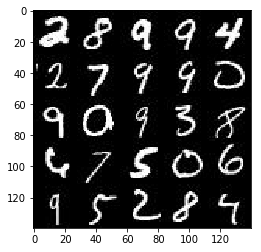

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

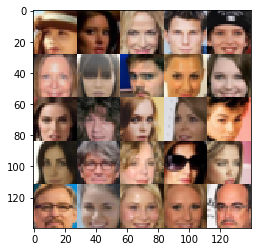

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input_images')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, (), name='learning_rate')
    
    return real_input_images, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Define Custom Activation Function

In [10]:
def leaky_relu(x, alpha=0.2):
    return tf.maximum(x * alpha, x)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [344]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # assume that images have shape 28x28x?
        
        layer1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        layer1_act = leaky_relu(layer1)
        # 14x14
        
        layer2 = tf.layers.conv2d(layer1_act, 256, 5, strides=2, padding='same')
        layer2_act = leaky_relu(layer2)
        # 7x7
        
        layer2_rs = tf.reshape(layer2_act, (-1, 7*7*256))
        
        logits = tf.layers.dense(layer2_rs, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [345]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        
        layer1 = tf.layers.dense(z, 7*7*256)
        layer1_rs = tf.reshape(layer1, (-1, 7, 7, 256))
        layer1_bn = tf.layers.batch_normalization(layer1_rs, training=is_train)
        layer1_act = leaky_relu(layer1_bn)
        # 7x7

        layer2 = tf.layers.conv2d_transpose(layer1_act, 128, 5, strides=2, padding='same')
        layer2_bn = tf.layers.batch_normalization(layer2, training=is_train)
        layer2_act = leaky_relu(layer2_bn)
        # 14x14
    
        logits = tf.layers.conv2d_transpose(layer2_act, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x?

        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [346]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [357]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    vars_ = tf.trainable_variables()
    g_vars = [var for var in vars_ if var.name.startswith('generator')]
    d_vars = [var for var in vars_ if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [358]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [359]:
import matplotlib.pyplot as plt

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_every=10, show_every=100, figsize=(5,5), n_images=25):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Step {}".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                    
    
    fig, ax = plt.subplots()
    losses = np.array(losses)
    plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
    plt.plot(losses.T[1], label='Generator', alpha=0.5)
    plt.title("Training Losses")
    plt.legend()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 10 Discriminator Loss: 0.4767... Generator Loss: 4.4849
Epoch 1/2... Step 20 Discriminator Loss: 1.5541... Generator Loss: 1.1903
Epoch 1/2... Step 30 Discriminator Loss: 1.1759... Generator Loss: 2.0696
Epoch 1/2... Step 40 Discriminator Loss: 1.3266... Generator Loss: 2.2518
Epoch 1/2... Step 50 Discriminator Loss: 1.1999... Generator Loss: 0.6714
Epoch 1/2... Step 60 Discriminator Loss: 1.0726... Generator Loss: 1.9716
Epoch 1/2... Step 70 Discriminator Loss: 1.3074... Generator Loss: 1.5770
Epoch 1/2... Step 80 Discriminator Loss: 1.2337... Generator Loss: 1.3933
Epoch 1/2... Step 90 Discriminator Loss: 1.8806... Generator Loss: 0.2541
Epoch 1/2... Step 100 Discriminator Loss: 0.9597... Generator Loss: 0.9980


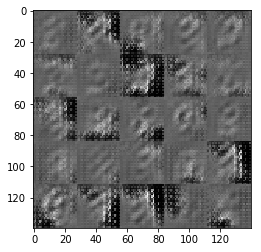

Epoch 1/2... Step 110 Discriminator Loss: 1.2222... Generator Loss: 1.2840
Epoch 1/2... Step 120 Discriminator Loss: 1.1570... Generator Loss: 0.6165
Epoch 1/2... Step 130 Discriminator Loss: 1.0366... Generator Loss: 1.6773
Epoch 1/2... Step 140 Discriminator Loss: 1.1922... Generator Loss: 0.7338
Epoch 1/2... Step 150 Discriminator Loss: 1.1799... Generator Loss: 1.3294
Epoch 1/2... Step 160 Discriminator Loss: 1.1535... Generator Loss: 0.7411
Epoch 1/2... Step 170 Discriminator Loss: 1.0415... Generator Loss: 1.6539
Epoch 1/2... Step 180 Discriminator Loss: 1.1606... Generator Loss: 3.1012
Epoch 1/2... Step 190 Discriminator Loss: 0.7715... Generator Loss: 2.2510
Epoch 1/2... Step 200 Discriminator Loss: 1.5889... Generator Loss: 4.1687


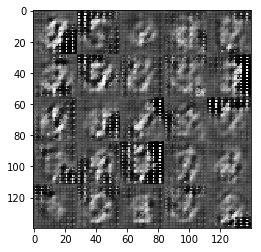

Epoch 1/2... Step 210 Discriminator Loss: 3.5346... Generator Loss: 0.0699
Epoch 1/2... Step 220 Discriminator Loss: 1.0767... Generator Loss: 0.8659
Epoch 1/2... Step 230 Discriminator Loss: 1.0182... Generator Loss: 2.1074
Epoch 1/2... Step 240 Discriminator Loss: 5.2714... Generator Loss: 6.4957
Epoch 1/2... Step 250 Discriminator Loss: 0.9683... Generator Loss: 2.0524
Epoch 1/2... Step 260 Discriminator Loss: 0.7826... Generator Loss: 1.9220
Epoch 1/2... Step 270 Discriminator Loss: 1.1496... Generator Loss: 0.8687
Epoch 1/2... Step 280 Discriminator Loss: 1.0242... Generator Loss: 1.7252
Epoch 1/2... Step 290 Discriminator Loss: 1.5009... Generator Loss: 0.4769
Epoch 1/2... Step 300 Discriminator Loss: 0.8983... Generator Loss: 2.6030


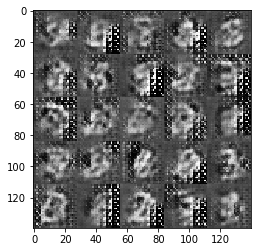

Epoch 1/2... Step 310 Discriminator Loss: 0.6284... Generator Loss: 3.3145
Epoch 1/2... Step 320 Discriminator Loss: 0.9973... Generator Loss: 1.9162
Epoch 1/2... Step 330 Discriminator Loss: 1.0335... Generator Loss: 1.5679
Epoch 1/2... Step 340 Discriminator Loss: 1.1252... Generator Loss: 1.2983
Epoch 1/2... Step 350 Discriminator Loss: 1.0212... Generator Loss: 1.4912
Epoch 1/2... Step 360 Discriminator Loss: 1.1434... Generator Loss: 1.0262
Epoch 1/2... Step 370 Discriminator Loss: 0.9872... Generator Loss: 1.3537
Epoch 1/2... Step 380 Discriminator Loss: 1.2735... Generator Loss: 0.5616
Epoch 1/2... Step 390 Discriminator Loss: 1.4948... Generator Loss: 0.4459
Epoch 1/2... Step 400 Discriminator Loss: 0.8919... Generator Loss: 1.4739


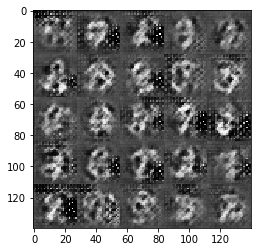

Epoch 1/2... Step 410 Discriminator Loss: 0.8861... Generator Loss: 1.6840
Epoch 1/2... Step 420 Discriminator Loss: 1.9084... Generator Loss: 2.0770
Epoch 1/2... Step 430 Discriminator Loss: 1.3375... Generator Loss: 1.7203
Epoch 1/2... Step 440 Discriminator Loss: 1.3781... Generator Loss: 0.5996
Epoch 1/2... Step 450 Discriminator Loss: 1.1340... Generator Loss: 1.8159
Epoch 1/2... Step 460 Discriminator Loss: 1.1719... Generator Loss: 2.3157
Epoch 2/2... Step 470 Discriminator Loss: 0.9286... Generator Loss: 1.5931
Epoch 2/2... Step 480 Discriminator Loss: 2.0640... Generator Loss: 0.2388
Epoch 2/2... Step 490 Discriminator Loss: 1.3493... Generator Loss: 0.5260
Epoch 2/2... Step 500 Discriminator Loss: 0.9795... Generator Loss: 1.2203


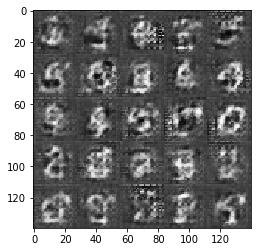

Epoch 2/2... Step 510 Discriminator Loss: 0.9897... Generator Loss: 0.9532
Epoch 2/2... Step 520 Discriminator Loss: 0.8433... Generator Loss: 1.2220
Epoch 2/2... Step 530 Discriminator Loss: 1.3372... Generator Loss: 0.9924
Epoch 2/2... Step 540 Discriminator Loss: 1.2957... Generator Loss: 0.8946
Epoch 2/2... Step 550 Discriminator Loss: 1.1219... Generator Loss: 0.9180
Epoch 2/2... Step 560 Discriminator Loss: 0.9704... Generator Loss: 1.5613
Epoch 2/2... Step 570 Discriminator Loss: 1.3223... Generator Loss: 0.5372
Epoch 2/2... Step 580 Discriminator Loss: 1.0034... Generator Loss: 2.1020
Epoch 2/2... Step 590 Discriminator Loss: 0.9394... Generator Loss: 1.2102
Epoch 2/2... Step 600 Discriminator Loss: 1.5512... Generator Loss: 2.4042


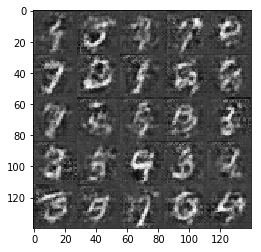

Epoch 2/2... Step 610 Discriminator Loss: 1.1182... Generator Loss: 1.3063
Epoch 2/2... Step 620 Discriminator Loss: 1.1371... Generator Loss: 2.1260
Epoch 2/2... Step 630 Discriminator Loss: 1.2426... Generator Loss: 0.6140
Epoch 2/2... Step 640 Discriminator Loss: 0.9894... Generator Loss: 0.9195
Epoch 2/2... Step 650 Discriminator Loss: 1.1676... Generator Loss: 0.9468
Epoch 2/2... Step 660 Discriminator Loss: 1.1110... Generator Loss: 2.1992
Epoch 2/2... Step 670 Discriminator Loss: 1.2909... Generator Loss: 0.6307
Epoch 2/2... Step 680 Discriminator Loss: 2.6751... Generator Loss: 0.1446
Epoch 2/2... Step 690 Discriminator Loss: 0.9730... Generator Loss: 1.2558
Epoch 2/2... Step 700 Discriminator Loss: 0.9917... Generator Loss: 0.9767


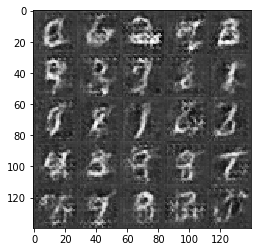

Epoch 2/2... Step 710 Discriminator Loss: 1.3680... Generator Loss: 0.5197
Epoch 2/2... Step 720 Discriminator Loss: 1.0018... Generator Loss: 1.3143
Epoch 2/2... Step 730 Discriminator Loss: 0.8038... Generator Loss: 1.5525
Epoch 2/2... Step 740 Discriminator Loss: 1.2453... Generator Loss: 1.9665
Epoch 2/2... Step 750 Discriminator Loss: 1.0250... Generator Loss: 1.1181
Epoch 2/2... Step 760 Discriminator Loss: 1.7128... Generator Loss: 1.8929
Epoch 2/2... Step 770 Discriminator Loss: 1.1241... Generator Loss: 0.7431
Epoch 2/2... Step 780 Discriminator Loss: 0.9434... Generator Loss: 0.9616
Epoch 2/2... Step 790 Discriminator Loss: 1.1573... Generator Loss: 0.7703
Epoch 2/2... Step 800 Discriminator Loss: 0.9933... Generator Loss: 0.8733


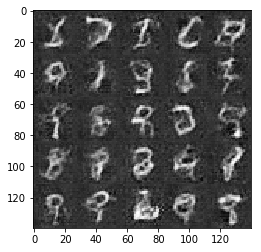

Epoch 2/2... Step 810 Discriminator Loss: 1.7464... Generator Loss: 0.4950
Epoch 2/2... Step 820 Discriminator Loss: 1.3033... Generator Loss: 0.5791
Epoch 2/2... Step 830 Discriminator Loss: 1.1190... Generator Loss: 0.7543
Epoch 2/2... Step 840 Discriminator Loss: 0.8119... Generator Loss: 1.3633
Epoch 2/2... Step 850 Discriminator Loss: 1.2469... Generator Loss: 0.6462
Epoch 2/2... Step 860 Discriminator Loss: 0.8683... Generator Loss: 2.0652
Epoch 2/2... Step 870 Discriminator Loss: 1.0442... Generator Loss: 1.9678
Epoch 2/2... Step 880 Discriminator Loss: 0.7982... Generator Loss: 1.7353
Epoch 2/2... Step 890 Discriminator Loss: 1.0113... Generator Loss: 1.3528
Epoch 2/2... Step 900 Discriminator Loss: 0.9337... Generator Loss: 1.1229


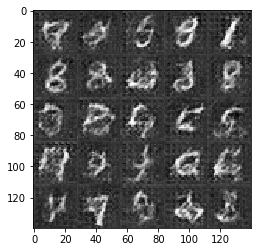

Epoch 2/2... Step 910 Discriminator Loss: 0.9813... Generator Loss: 1.0429
Epoch 2/2... Step 920 Discriminator Loss: 0.9117... Generator Loss: 0.9864
Epoch 2/2... Step 930 Discriminator Loss: 1.2256... Generator Loss: 2.1623


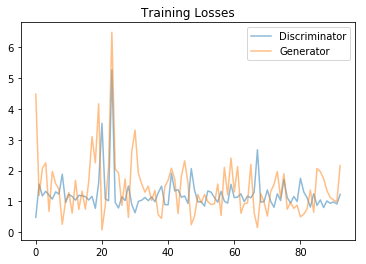

In [364]:
batch_size = 128
z_dim = 150
learning_rate = 0.002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step 10 Discriminator Loss: 0.4729... Generator Loss: 7.3065
Epoch 1/1... Step 20 Discriminator Loss: 0.4894... Generator Loss: 6.8281
Epoch 1/1... Step 30 Discriminator Loss: 0.5514... Generator Loss: 4.5478
Epoch 1/1... Step 40 Discriminator Loss: 1.1964... Generator Loss: 2.4345
Epoch 1/1... Step 50 Discriminator Loss: 0.7053... Generator Loss: 1.9305
Epoch 1/1... Step 60 Discriminator Loss: 0.9255... Generator Loss: 1.9492
Epoch 1/1... Step 70 Discriminator Loss: 0.7929... Generator Loss: 2.2339
Epoch 1/1... Step 80 Discriminator Loss: 1.1682... Generator Loss: 5.4649
Epoch 1/1... Step 90 Discriminator Loss: 0.8525... Generator Loss: 2.8421
Epoch 1/1... Step 100 Discriminator Loss: 0.8443... Generator Loss: 1.3512


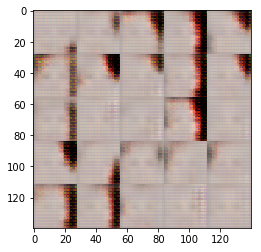

Epoch 1/1... Step 110 Discriminator Loss: 0.7715... Generator Loss: 2.4559
Epoch 1/1... Step 120 Discriminator Loss: 0.8412... Generator Loss: 1.7851
Epoch 1/1... Step 130 Discriminator Loss: 0.7240... Generator Loss: 3.3037
Epoch 1/1... Step 140 Discriminator Loss: 1.3499... Generator Loss: 1.3845
Epoch 1/1... Step 150 Discriminator Loss: 0.9176... Generator Loss: 2.2387
Epoch 1/1... Step 160 Discriminator Loss: 0.8602... Generator Loss: 2.3712
Epoch 1/1... Step 170 Discriminator Loss: 0.8010... Generator Loss: 3.4944
Epoch 1/1... Step 180 Discriminator Loss: 0.9162... Generator Loss: 2.5460
Epoch 1/1... Step 190 Discriminator Loss: 1.0202... Generator Loss: 4.8205
Epoch 1/1... Step 200 Discriminator Loss: 0.9085... Generator Loss: 1.7931


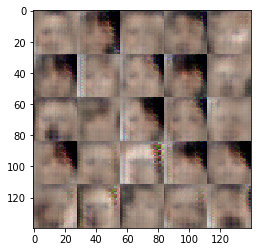

Epoch 1/1... Step 210 Discriminator Loss: 0.8990... Generator Loss: 2.1071
Epoch 1/1... Step 220 Discriminator Loss: 0.8693... Generator Loss: 3.2846
Epoch 1/1... Step 230 Discriminator Loss: 0.9047... Generator Loss: 2.1193
Epoch 1/1... Step 240 Discriminator Loss: 0.9411... Generator Loss: 4.7435
Epoch 1/1... Step 250 Discriminator Loss: 0.7875... Generator Loss: 3.3938
Epoch 1/1... Step 260 Discriminator Loss: 1.0340... Generator Loss: 2.0425
Epoch 1/1... Step 270 Discriminator Loss: 1.0490... Generator Loss: 1.7580
Epoch 1/1... Step 280 Discriminator Loss: 2.0164... Generator Loss: 0.4317
Epoch 1/1... Step 290 Discriminator Loss: 1.0507... Generator Loss: 1.9732
Epoch 1/1... Step 300 Discriminator Loss: 0.9966... Generator Loss: 1.7830


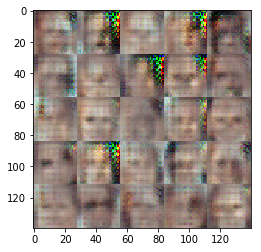

Epoch 1/1... Step 310 Discriminator Loss: 1.0093... Generator Loss: 3.0705
Epoch 1/1... Step 320 Discriminator Loss: 0.8674... Generator Loss: 3.0151
Epoch 1/1... Step 330 Discriminator Loss: 0.8832... Generator Loss: 3.7515
Epoch 1/1... Step 340 Discriminator Loss: 1.0702... Generator Loss: 1.0180
Epoch 1/1... Step 350 Discriminator Loss: 1.3073... Generator Loss: 0.7157
Epoch 1/1... Step 360 Discriminator Loss: 0.9485... Generator Loss: 2.2024
Epoch 1/1... Step 370 Discriminator Loss: 1.1062... Generator Loss: 1.8583
Epoch 1/1... Step 380 Discriminator Loss: 1.1799... Generator Loss: 0.9178
Epoch 1/1... Step 390 Discriminator Loss: 1.0598... Generator Loss: 1.9149
Epoch 1/1... Step 400 Discriminator Loss: 1.0857... Generator Loss: 1.9213


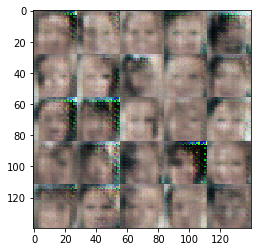

Epoch 1/1... Step 410 Discriminator Loss: 0.9545... Generator Loss: 1.7660
Epoch 1/1... Step 420 Discriminator Loss: 1.1808... Generator Loss: 3.2631
Epoch 1/1... Step 430 Discriminator Loss: 1.0743... Generator Loss: 1.3399
Epoch 1/1... Step 440 Discriminator Loss: 1.4180... Generator Loss: 3.3361
Epoch 1/1... Step 450 Discriminator Loss: 1.0266... Generator Loss: 2.5056
Epoch 1/1... Step 460 Discriminator Loss: 7.2422... Generator Loss: 0.0246
Epoch 1/1... Step 470 Discriminator Loss: 1.2949... Generator Loss: 1.0137
Epoch 1/1... Step 480 Discriminator Loss: 1.5935... Generator Loss: 0.4670
Epoch 1/1... Step 490 Discriminator Loss: 1.1162... Generator Loss: 1.7814
Epoch 1/1... Step 500 Discriminator Loss: 1.1920... Generator Loss: 1.0845


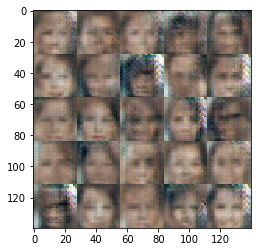

Epoch 1/1... Step 510 Discriminator Loss: 1.1719... Generator Loss: 1.8468
Epoch 1/1... Step 520 Discriminator Loss: 1.2730... Generator Loss: 1.5551
Epoch 1/1... Step 530 Discriminator Loss: 1.0628... Generator Loss: 1.5268
Epoch 1/1... Step 540 Discriminator Loss: 1.2109... Generator Loss: 1.3344
Epoch 1/1... Step 550 Discriminator Loss: 1.0225... Generator Loss: 1.8617
Epoch 1/1... Step 560 Discriminator Loss: 1.1331... Generator Loss: 1.1817
Epoch 1/1... Step 570 Discriminator Loss: 1.2403... Generator Loss: 0.8108
Epoch 1/1... Step 580 Discriminator Loss: 1.2511... Generator Loss: 1.4800
Epoch 1/1... Step 590 Discriminator Loss: 1.1616... Generator Loss: 1.3322
Epoch 1/1... Step 600 Discriminator Loss: 1.0833... Generator Loss: 1.7656


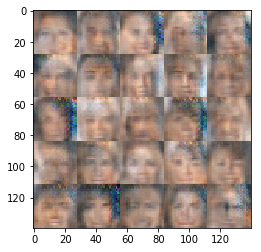

Epoch 1/1... Step 610 Discriminator Loss: 1.3259... Generator Loss: 0.8047
Epoch 1/1... Step 620 Discriminator Loss: 1.1006... Generator Loss: 1.2477
Epoch 1/1... Step 630 Discriminator Loss: 1.1667... Generator Loss: 1.1474
Epoch 1/1... Step 640 Discriminator Loss: 1.0925... Generator Loss: 1.2391
Epoch 1/1... Step 650 Discriminator Loss: 0.8979... Generator Loss: 2.4612
Epoch 1/1... Step 660 Discriminator Loss: 1.2515... Generator Loss: 1.3597
Epoch 1/1... Step 670 Discriminator Loss: 1.1778... Generator Loss: 1.1476
Epoch 1/1... Step 680 Discriminator Loss: 1.2149... Generator Loss: 1.3141
Epoch 1/1... Step 690 Discriminator Loss: 1.6187... Generator Loss: 1.7364
Epoch 1/1... Step 700 Discriminator Loss: 1.2621... Generator Loss: 0.8422


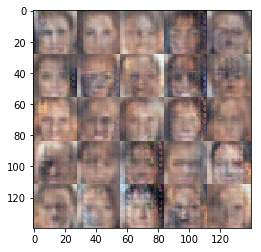

Epoch 1/1... Step 710 Discriminator Loss: 1.1330... Generator Loss: 1.0245
Epoch 1/1... Step 720 Discriminator Loss: 0.8292... Generator Loss: 6.1257
Epoch 1/1... Step 730 Discriminator Loss: 0.7533... Generator Loss: 3.0741
Epoch 1/1... Step 740 Discriminator Loss: 0.9774... Generator Loss: 1.6627
Epoch 1/1... Step 750 Discriminator Loss: 1.5266... Generator Loss: 0.4499
Epoch 1/1... Step 760 Discriminator Loss: 1.1603... Generator Loss: 1.8795
Epoch 1/1... Step 770 Discriminator Loss: 0.9602... Generator Loss: 1.4138
Epoch 1/1... Step 780 Discriminator Loss: 2.1075... Generator Loss: 0.2189
Epoch 1/1... Step 790 Discriminator Loss: 1.4268... Generator Loss: 0.8598
Epoch 1/1... Step 800 Discriminator Loss: 1.2906... Generator Loss: 1.3498


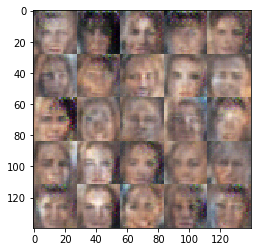

Epoch 1/1... Step 810 Discriminator Loss: 1.2502... Generator Loss: 0.9593
Epoch 1/1... Step 820 Discriminator Loss: 1.3424... Generator Loss: 0.8270
Epoch 1/1... Step 830 Discriminator Loss: 1.4092... Generator Loss: 0.6310
Epoch 1/1... Step 840 Discriminator Loss: 1.2127... Generator Loss: 0.9943
Epoch 1/1... Step 850 Discriminator Loss: 1.1197... Generator Loss: 1.5775
Epoch 1/1... Step 860 Discriminator Loss: 1.1920... Generator Loss: 1.3278
Epoch 1/1... Step 870 Discriminator Loss: 1.2349... Generator Loss: 0.7485
Epoch 1/1... Step 880 Discriminator Loss: 1.3057... Generator Loss: 0.6694
Epoch 1/1... Step 890 Discriminator Loss: 0.9972... Generator Loss: 1.4223
Epoch 1/1... Step 900 Discriminator Loss: 1.1030... Generator Loss: 1.0622


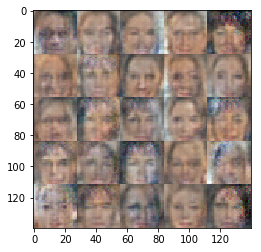

Epoch 1/1... Step 910 Discriminator Loss: 1.1931... Generator Loss: 1.1430
Epoch 1/1... Step 920 Discriminator Loss: 1.1200... Generator Loss: 1.2367
Epoch 1/1... Step 930 Discriminator Loss: 1.1462... Generator Loss: 0.9871
Epoch 1/1... Step 940 Discriminator Loss: 1.0690... Generator Loss: 1.3045
Epoch 1/1... Step 950 Discriminator Loss: 1.2292... Generator Loss: 0.7959
Epoch 1/1... Step 960 Discriminator Loss: 1.1242... Generator Loss: 0.9365
Epoch 1/1... Step 970 Discriminator Loss: 1.4410... Generator Loss: 2.6210
Epoch 1/1... Step 980 Discriminator Loss: 1.0737... Generator Loss: 1.5798
Epoch 1/1... Step 990 Discriminator Loss: 1.1804... Generator Loss: 1.0729
Epoch 1/1... Step 1000 Discriminator Loss: 1.3186... Generator Loss: 0.6807


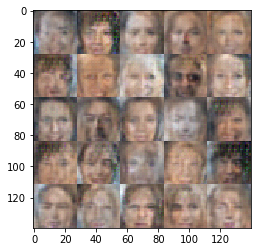

Epoch 1/1... Step 1010 Discriminator Loss: 1.0606... Generator Loss: 1.5071
Epoch 1/1... Step 1020 Discriminator Loss: 1.1656... Generator Loss: 1.0347
Epoch 1/1... Step 1030 Discriminator Loss: 1.2276... Generator Loss: 1.9470
Epoch 1/1... Step 1040 Discriminator Loss: 1.1362... Generator Loss: 1.7942
Epoch 1/1... Step 1050 Discriminator Loss: 1.0547... Generator Loss: 2.0720
Epoch 1/1... Step 1060 Discriminator Loss: 1.6226... Generator Loss: 0.4062
Epoch 1/1... Step 1070 Discriminator Loss: 1.1682... Generator Loss: 0.7869
Epoch 1/1... Step 1080 Discriminator Loss: 1.4926... Generator Loss: 0.5216
Epoch 1/1... Step 1090 Discriminator Loss: 1.5574... Generator Loss: 0.4481
Epoch 1/1... Step 1100 Discriminator Loss: 1.1885... Generator Loss: 1.1335


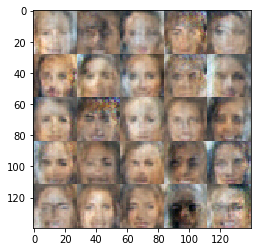

Epoch 1/1... Step 1110 Discriminator Loss: 1.2403... Generator Loss: 1.5090
Epoch 1/1... Step 1120 Discriminator Loss: 1.2794... Generator Loss: 0.6926
Epoch 1/1... Step 1130 Discriminator Loss: 1.2185... Generator Loss: 0.8806
Epoch 1/1... Step 1140 Discriminator Loss: 1.2173... Generator Loss: 1.1167
Epoch 1/1... Step 1150 Discriminator Loss: 1.2589... Generator Loss: 0.9743
Epoch 1/1... Step 1160 Discriminator Loss: 1.3814... Generator Loss: 0.5818
Epoch 1/1... Step 1170 Discriminator Loss: 1.4713... Generator Loss: 0.7934
Epoch 1/1... Step 1180 Discriminator Loss: 1.3962... Generator Loss: 0.5686
Epoch 1/1... Step 1190 Discriminator Loss: 1.2153... Generator Loss: 1.0919
Epoch 1/1... Step 1200 Discriminator Loss: 1.8052... Generator Loss: 0.3571


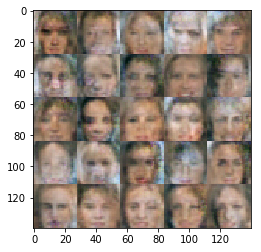

Epoch 1/1... Step 1210 Discriminator Loss: 1.2347... Generator Loss: 0.8146
Epoch 1/1... Step 1220 Discriminator Loss: 1.1984... Generator Loss: 1.1848
Epoch 1/1... Step 1230 Discriminator Loss: 1.4104... Generator Loss: 1.7443
Epoch 1/1... Step 1240 Discriminator Loss: 1.3481... Generator Loss: 1.6156
Epoch 1/1... Step 1250 Discriminator Loss: 1.1477... Generator Loss: 1.3420
Epoch 1/1... Step 1260 Discriminator Loss: 1.2605... Generator Loss: 0.8198
Epoch 1/1... Step 1270 Discriminator Loss: 1.1641... Generator Loss: 1.2428
Epoch 1/1... Step 1280 Discriminator Loss: 1.2956... Generator Loss: 1.6133
Epoch 1/1... Step 1290 Discriminator Loss: 1.2400... Generator Loss: 0.9768
Epoch 1/1... Step 1300 Discriminator Loss: 1.1570... Generator Loss: 0.8616


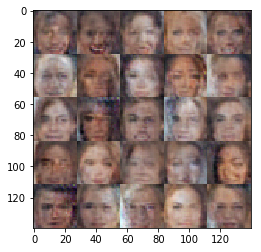

Epoch 1/1... Step 1310 Discriminator Loss: 1.2408... Generator Loss: 0.7897
Epoch 1/1... Step 1320 Discriminator Loss: 1.1950... Generator Loss: 0.8521
Epoch 1/1... Step 1330 Discriminator Loss: 1.4680... Generator Loss: 1.5125
Epoch 1/1... Step 1340 Discriminator Loss: 1.3588... Generator Loss: 1.0463
Epoch 1/1... Step 1350 Discriminator Loss: 1.4543... Generator Loss: 1.7891
Epoch 1/1... Step 1360 Discriminator Loss: 1.3865... Generator Loss: 0.6026
Epoch 1/1... Step 1370 Discriminator Loss: 1.2436... Generator Loss: 0.8052
Epoch 1/1... Step 1380 Discriminator Loss: 1.4181... Generator Loss: 0.5245
Epoch 1/1... Step 1390 Discriminator Loss: 1.3407... Generator Loss: 0.9563
Epoch 1/1... Step 1400 Discriminator Loss: 1.1545... Generator Loss: 1.5215


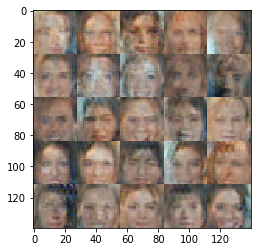

Epoch 1/1... Step 1410 Discriminator Loss: 1.3259... Generator Loss: 1.7367
Epoch 1/1... Step 1420 Discriminator Loss: 1.3541... Generator Loss: 0.5932
Epoch 1/1... Step 1430 Discriminator Loss: 1.4741... Generator Loss: 1.6697
Epoch 1/1... Step 1440 Discriminator Loss: 1.2131... Generator Loss: 1.2736
Epoch 1/1... Step 1450 Discriminator Loss: 1.1115... Generator Loss: 0.9389
Epoch 1/1... Step 1460 Discriminator Loss: 1.2763... Generator Loss: 0.9281
Epoch 1/1... Step 1470 Discriminator Loss: 1.2494... Generator Loss: 0.9258
Epoch 1/1... Step 1480 Discriminator Loss: 1.5790... Generator Loss: 0.4515
Epoch 1/1... Step 1490 Discriminator Loss: 1.3032... Generator Loss: 0.6432
Epoch 1/1... Step 1500 Discriminator Loss: 1.3251... Generator Loss: 0.7474


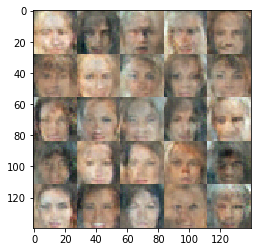

Epoch 1/1... Step 1510 Discriminator Loss: 1.2407... Generator Loss: 1.5022
Epoch 1/1... Step 1520 Discriminator Loss: 1.3717... Generator Loss: 0.6708
Epoch 1/1... Step 1530 Discriminator Loss: 1.2036... Generator Loss: 0.7937
Epoch 1/1... Step 1540 Discriminator Loss: 1.0929... Generator Loss: 0.9437
Epoch 1/1... Step 1550 Discriminator Loss: 1.2572... Generator Loss: 1.4053
Epoch 1/1... Step 1560 Discriminator Loss: 1.2031... Generator Loss: 0.9044
Epoch 1/1... Step 1570 Discriminator Loss: 1.0582... Generator Loss: 1.1702
Epoch 1/1... Step 1580 Discriminator Loss: 1.2526... Generator Loss: 0.9072


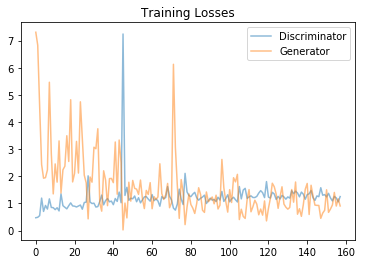

In [361]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.